In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive/GitHub Repositories')

segmenModelweights = './State of Art Segmentation Network Architectures/saved models/U-NET Lungs Segmentation Model/Lungs Segmentation Mode with best weights.hdf5'
classModelweights = './Visual Explaination from Deep Neural Networks/Grad-CAM Approach/saved models/Grad-CAM-best-weights.hdf5'

In [3]:
#Load Segmentation Model Weights

import os
from keras.models import *
from keras.layers import *
from keras.optimizers import *

IMG_SIZE = 512

def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(IMG_SIZE, IMG_SIZE, 1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10]) 

segmenModel = unet(input_size=(IMG_SIZE, IMG_SIZE, 1))
segmenModel.load_weights(segmenModelweights)
segmenModel.summary()
print('Segmentation Model Loaded Successfully') 


Using TensorFlow backend.












Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 32) 0           conv2d_2[0][0]                   
__________________________________________________________________________________

In [4]:
from keras.applications.vgg16 import VGG16
import numpy as np

IMG_SIZE = 512
img_shape = (IMG_SIZE, IMG_SIZE, 3)
inputs = Input(img_shape)
num_classes = 2

def ClassificationModel():
  vgg16 = VGG16(input_shape =  img_shape, include_top = False, weights = 'imagenet')
  vgg16.trainable = False
  vgg16_depth = vgg16.get_output_shape_at(0)[-1]
  vgg16_outputs = vgg16(inputs)
  bn_outputs = BatchNormalization(name='BatchNormalization')(vgg16_outputs)

  # here we do an attention mechanism to turn pixels in the GAP on an off
  atten_outputs = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(bn_outputs)
  atten_outputs = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(atten_outputs)
  atten_outputs = Conv2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid')(atten_outputs)

  # fan it out to all of the channels
  weights = np.ones((1, 1, 1, vgg16_depth))
  outputs_up_c2 = Conv2D(vgg16_depth, kernel_size = (1,1), padding = 'same', activation = 'linear', use_bias = False, weights = [weights])
  outputs_up_c2.trainable = False
  atten_outputs = outputs_up_c2(atten_outputs)

  multiply_outputs = multiply([atten_outputs, bn_outputs], name='Multiply')
  gap_features_ouputs = GlobalAveragePooling2D()(multiply_outputs)
  gap_mask_ouputs = GlobalAveragePooling2D()(atten_outputs)

  # to account for missing values from the attention model
  outputs = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features_ouputs, gap_mask_ouputs])
  outputs = Dropout(0.5)(outputs)
  outputs = Dense(128, activation = 'elu')(outputs)
  outputs = Dropout(0.25)(outputs)
  outputs = Dense(num_classes, activation = 'softmax')(outputs)

  return Model(inputs = [inputs], outputs = [outputs])
    

classModel = ClassificationModel()
classModel.load_weights(classModelweights)
classModel.summary()
print('Prediction Model Loaded Successfully') 

58892288/58889256 [==============================] - 1s 0us/step


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 16, 16, 512)  14714688    input_2[0][0]                    
__________________________________________________________________________________________________
BatchNormalization (BatchNormal (None, 16, 16, 512)  2048        vgg16[1][0]                      
__________________________________________________________________________________________________
conv2d_20

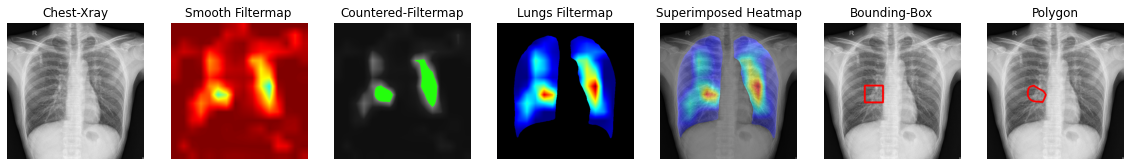

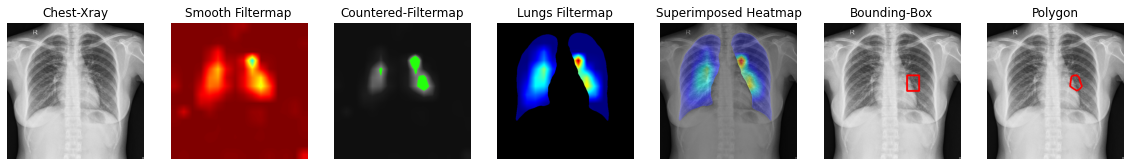

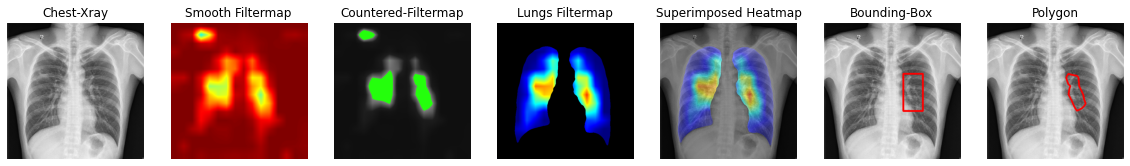

In [21]:
from keras.preprocessing.image import load_img, img_to_array, save_img
import cv2
import matplotlib.pyplot as plt
import numpy as np

dataDir = './Visual Explaination from Deep Neural Networks/dataset/samples'
images = sorted(os.listdir(dataDir), reverse=True)

def GetandSave_Mask(imgName):
  masksFolder = os.path.join('./Visual Explaination from Deep Neural Networks', 'dataset', 'Extracted Masks')
  if not os.path.exists(masksFolder):
      os.makedirs(masksFolder)
  img = img_to_array(load_img(os.path.join(dataDir, imgName), color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE),
                            interpolation='lanczos'))
  img = np.float32((img-127.0)/127.0)
  img  =img.reshape(-1, 512, 512, 1)
  mask = segmenModel.predict(img)
  save_img(os.path.join(masksFolder, 'mask_'+imgName), mask[0, :, :, :], data_format=None, file_format=None, scale=True)

def PredictClass(imgName):
    img = img_to_array(load_img(os.path.join(dataDir, imgName), target_size=(IMG_SIZE, IMG_SIZE), interpolation='lanczos'))
    img = np.float32(img/255.0)
    img_array = img.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    predictions = classModel.predict(img_array)
    return img_array, predictions

def GetFilterMap(img, predictions):
    class_idx = np.argmax(predictions[0])
    class_output = classModel.output[:, class_idx]
    last_conv_layer = classModel.get_layer("Multiply")

    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([classModel.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([img])
    
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    filtermap = np.mean(conv_layer_output_value, axis=-1)
    filtermap = np.maximum(filtermap, 0)
    filtermap /= np.max(filtermap)
    return filtermap  

def FiltermapSmoothing(imgName, filtermap):
    img = np.asarray(load_img(os.path.join(dataDir, imgName), target_size=(IMG_SIZE, IMG_SIZE),
                              interpolation='lanczos'))
    filtermap = cv2.resize(filtermap, (IMG_SIZE, IMG_SIZE)) # Resizing
    '''
    The minimum pixel value will be mapped to the minimum output value (alpha - 0)
    The maximum pixel value will be mapped to the maximum output value (beta - 155)
    Linear scaling is applied to everything in between.
    These values were chosen with trial and error using COLORMAP_JET to deliver the best pixel saturation for forming contours.
    '''
    smoothfiltermap = cv2.normalize(filtermap, None, alpha=0, beta=155, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    smoothfiltermap = cv2.applyColorMap(smoothfiltermap, cv2.COLORMAP_JET)
    return smoothfiltermap

def ContouredFiltermap(grey_img, contours):
  img_col = cv2.merge([grey_img, grey_img, grey_img]) # merge channels to create color image (3 channels)
  contouredfiltermap = cv2.fillPoly(img_col, contours, [36, 255, 12]) # fill contours on 3 channel image
  return contouredfiltermap

def GenerateBoundingBoxes(smoothfiltermap):
  scale_list = [1, 1, 1, 1] 
  grey_img = cv2.cvtColor(smoothfiltermap, cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(grey_img, 127, 255, cv2.THRESH_BINARY)
  contours, hierarchy = cv2.findContours(thresh, 1, 2)

  for item in range(len(contours)):
    cnt = contours[item]
    if len(cnt) > 20:
        x, y, w, h = cv2.boundingRect(cnt) # x, y is the top left corner, and w, h are the width and height respectively
        poly_coords = [cnt] # polygon coordinates are based on contours
        
        x = int(x * scale_list[0]) # rescaling the boundary box based on user input
        y = int(y * scale_list[1])
        w = int(w * scale_list[2])
        h = int(h * scale_list[3])
        
        return x, y, w, h, poly_coords, grey_img, contours
    
    else: print("contour error (too small)")
     

def GenerateHeatMap(filtermap, imgName):
  filtermap = cv2.resize(filtermap, (IMG_SIZE, IMG_SIZE))
  filtermap = np.uint8(255 * filtermap)
  filtermap = cv2.applyColorMap(filtermap, cv2.COLORMAP_JET)
  filtermap = cv2.cvtColor(filtermap, cv2.COLOR_BGR2RGB)

  mask = np.asarray(load_img(os.path.join('./Visual Explaination from Deep Neural Networks/dataset/Extracted Masks', 'mask_'+imgName), 
                               target_size=(IMG_SIZE, IMG_SIZE), interpolation='lanczos'))
  black_pixels_mask = np.all(mask == [0, 0, 0], axis=-1)
  img = np.asarray(load_img(os.path.join(dataDir, imgName), target_size=(IMG_SIZE, IMG_SIZE),
                              interpolation='lanczos'))

  filtermap[black_pixels_mask] = [0, 0, 0]
  superimposed_img = cv2.addWeighted(img, 0.6, filtermap, 0.5, 0)
  return filtermap, superimposed_img

def PlotResults(xray, smoothfiltermap, counteredfiltermap, filtermap, superimposed_img, BoundingBoxImage, PolygonImage):
  plt.figure(figsize = (20, 20))  
    
  plt.subplot(1, 7, 1)
  plt.imshow(xray)
  plt.title('Chest-Xray')
  plt.axis('off')
  
  plt.subplot(1, 7, 2)
  plt.imshow(smoothfiltermap, vmin=0, vmax=255)
  plt.title('Smooth Filtermap')
  plt.axis('off')
  
  plt.subplot(1, 7, 3)
  plt.imshow(counteredfiltermap, vmin=0, vmax=255)
  plt.title('Countered-Filtermap')
  plt.axis('off')
  
  
  plt.subplot(1, 7, 4)
  plt.imshow(filtermap, vmin=0, vmax=255)
  plt.title('Lungs Filtermap')
  plt.axis('off')
  
  plt.subplot(1, 7, 5)
  plt.imshow(superimposed_img, vmin=0, vmax=255)
  plt.title('Superimposed Heatmap')
  plt.axis('off')

  plt.subplot(1, 7, 6)
  plt.imshow(BoundingBoxImage, vmin=0, vmax=255)
  plt.title('Bounding-Box')
  plt.axis('off')

  plt.subplot(1, 7, 7)
  plt.imshow(PolygonImage, vmin=0, vmax=255)
  plt.title('Polygon')
  plt.axis('off')

  plt.show()  
  plt.close()  


for imgName in images:
  xray = load_img(os.path.join(dataDir, imgName), target_size=(IMG_SIZE, IMG_SIZE), interpolation='lanczos')

  GetandSave_Mask(imgName)
  img_array, predictions = PredictClass(imgName)
  realLabel = imgName[-5]
  if np.argmax(predictions[0]) == 1:

    filtermap = GetFilterMap(img_array, predictions)
    
    smoothfiltermap = FiltermapSmoothing(imgName, filtermap)

    x, y, w, h, poly_coords, grey_img, contours= GenerateBoundingBoxes(smoothfiltermap)
    img2bbox = np.asarray(load_img(os.path.join(dataDir, imgName), target_size=(IMG_SIZE, IMG_SIZE),
                              interpolation='lanczos'))
    BoundingBoxImage= cv2.rectangle(img2bbox, (x, y), (x+w,  y+h), (255, 0, 0), 6)
    
    img2polygon = np.asarray(load_img(os.path.join(dataDir, imgName), target_size=(IMG_SIZE, IMG_SIZE),
                              interpolation='lanczos'))
    contouredfiltermap = ContouredFiltermap(grey_img, contours)
    PolygonImage = cv2.polylines(img2polygon, poly_coords, True, (255, 0, 0), 6)
    
    filtermap, superimposed_img = GenerateHeatMap(filtermap, imgName)
    
    PlotResults(xray, smoothfiltermap, contouredfiltermap, filtermap, superimposed_img, BoundingBoxImage, PolygonImage)
  


    
 